In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import IntEnum
from GrU import (GrU, evaluate, getBestExporter, getCost)
from A_star import (getAStarMatrices, estimateTotalDemandUsingAStar)

In [2]:
class source( IntEnum ):
    grid =  0
    pv = 1
    storage = 2
    charge = 3
    discharge = 4

# For clock data
class clock( IntEnum ):
    pv = 0
    storage = 1
    charge = 2
    discharge = 3

### Read Clock Auction data

#### Auctioneer Data

In [3]:
df_auctioneer_data = pd.read_csv('../data/Auctioneer Data.csv')
df_auctioneer_data.head()

,GMT,GRID_PRICE,PV_LIMIT,CAPACITY_LIMIT,CHARGING_LIMIT,DISCHARGING_LIMIT,TOTAL_DEMAND_25
0,16/10/2013 23:00,0.313789,0.0,54,14.72,14.72,6.977
1,17/10/2013 0:00,0.240782,0.0,54,14.72,14.72,4.481
2,17/10/2013 1:00,0.193476,0.0,54,14.72,14.72,5.309
3,17/10/2013 2:00,0.174946,0.0,54,14.72,14.72,3.792
4,17/10/2013 3:00,0.165518,0.0,54,14.72,14.72,3.726


In [4]:
grid_price = df_auctioneer_data.GRID_PRICE.to_numpy()
total_demand = df_auctioneer_data.TOTAL_DEMAND_25.to_numpy()

#### Deserialized Clock Auction Data

In [5]:
headers = np.load(file='../data/clock_data_columns.npy', allow_pickle=True)
df_clock_data = pd.DataFrame(np.load('../data/clock_data_values.npy', allow_pickle=True), columns=headers)
df_clock_data.head()

,,price_0,agent10,agent20,agent30,agent40,agent50,agent60,agent70,agent80,...,agent16308,agent17308,agent18308,agent19308,agent20308,agent21308,agent22308,agent23308,agent24308,agent25308
0,pv energy,"[0.294, 0.294, 0.294, 0.294, 0.294, 0.294, 0.2...","[0.478999984, 3.87296265e-10, 0.0, 0.0, 0.0, 0...","[0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.143999967, 1.18208509e-08, 1.44700266e-09, ...","[0.198, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.231, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.167989864, 6.64264657e-06, 3.48053605e-06, ...","[0.396, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[0.687, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.072...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.084...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,battery capacity,"[0.0005, 0.0005, 0.0005, 0.0005, 0.0006, 0.000...","[2.74403334e-10, 1.33083483e-09, 5.01277792e-0...","[-9.81067013e-09, -9.79115224e-09, -8.81444199...","[1.18061477e-08, 1.28772292e-08, 7.86139633e-0...","[-9.73803033e-09, -9.71098552e-09, -8.3321723e...","[-8.92445168e-09, -8.81317291e-09, -3.25900339...","[6.56324107e-06, 7.26724526e-06, 4.12884047e-0...","[-9.81057924e-09, -9.79167182e-09, -8.84118961...","[-9.81067563e-09, -9.79110804e-09, -8.81375623...",...,"[-9.84407936e-09, 0.00215252642, 0.00858990396...","[-9.84459912e-09, 0.00211607904, 0.490310994, ...","[-9.84498471e-09, 0.00206228085, 0.00838885685...","[-9.84498471e-09, 0.00206229906, 0.00838887514...","[-9.84444614e-09, 0.0021160792, 0.107308191, 0...","[-9.84498471e-09, 0.00206229904, 0.00838887512...","[-9.84498471e-09, 0.00206229902, 0.0083888747,...","[-9.84449295e-09, 0.00211135807, 0.00849786321...","[-9.84498471e-09, 0.00206229904, 0.00838887513...","[-9.8444929e-09, 0.00211135805, 0.00849787483,..."
2,battery charging power,"[0.01, 0.01, 0.01, 0.01, 0.013, 0.012, 0.01, 0...","[2.74403334e-10, 1.05643149e-09, 4.87969443e-0...","[0.0, 1.95178837e-11, 9.76710258e-10, 0.002922...","[1.18061477e-08, 1.07108143e-09, 6.57367341e-0...","[0.0, 2.70448091e-11, 1.37881322e-09, 0.002970...","[0.0, 1.11278774e-10, 5.55416951e-09, 0.002922...","[6.56324107e-06, 7.04004187e-07, 3.40211595e-0...","[0.0, 1.89074151e-11, 9.5048221e-10, 0.0029227...","[0.0, 1.95675814e-11, 9.77351819e-10, 0.002922...",...,"[0.0, 0.00215254, 0.00643738, 0.00640003, 0.00...","[0.0, 0.00211609, 0.48819491, 0.00636419, 0.00...","[0.0, 0.00206229, 0.00632658, 0.0063116, 0.006...","[0.0, 0.00206231, 0.00632658, 0.00631173, 0.00...","[0.0, 0.00211609, 0.10519211, 0.00636419, 0.00...","[0.0, 0.00206231, 0.00632658, 0.00631173, 0.00...","[0.0, 0.00206231, 0.00632658, 0.00631173, 0.00...","[0.0, 0.00211137, 0.00638651, 0.00635956, 0.96...","[0.0, 0.00206231, 0.00632658, 0.00631173, 0.00...","[0.0, 0.00211137, 0.00638652, 0.00635956, 0.97..."
3,battery discharging power,"[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00096589, 0.2...","[9.81067013e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00096588, 0.0...","[9.73803033e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[8.92445168e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.000965503264,...","[9.81057924e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...","[9.81067563e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00...",...,"[9.84407936e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[9.84459912e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[9.84498471e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[9.84498471e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[9.84444614e-09, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[9.84498471e-09, 0.

#### Vectors from Clock Auction Data

In [6]:
def estimateTotalDemand(agent, interpolate):
    '''
    Estimates the total demand using PV Energy demand and Discharing Power demand.

    Parameters
    ----------
    agent : int
        Agent number to estimate the total demand for, range = [1, 25]

    interpolate : bool
        Whether to interpolates total demand for bad hours (time slot 1-6).

    Returns
    -------
    dem : ndarray of shape (24, )
        Total demand of a user.
    '''
    tmp = np.zeros((24,))
    dem = np.zeros((24,))

    for r in range(309):
        col = f'agent{agent}{r}'

        tmp = df_clock_data[col][clock.pv] + df_clock_data[col][clock.discharge]
        dem = np.maximum(tmp, dem)

    if interpolate:
        dem[1 : 7] = (dem[0] + dem[7]) / 2

    return dem


def getTrueDemandVectors(round, agent):
    '''
    Fetch the true breakup of demands from Clock Auction data.
    
    Parameters
    ----------
    round : int
        Round number to get the true demand breakup for, range = [0, 308]

    agent : int
        Agent number to get the true demand breakup for, range = [1, 25]

    Returns
    -------
    demands : ndarray of shape (4, 24)
        Breakup of total demand in order p, s, c, d.
    '''
    col = f'agent{agent}{round}'

    demands = np.ndarray((4, 24))
    for e in clock:
        demands[e] = df_clock_data[col][e]
    
    return demands
    

def getPriceVectors(round):
    '''
    Get price vectors for a round from the clock data.

    Parameters
    ----------
    round : int
        Round number to get the price vectors for, range = [0, 308]

    Returns
    -------
    prices : ndarray of shape (5, 24)
        Price vectors for g, p, s, c, d.
    
    '''
    prices = np.ndarray((5, 24))
    prices[0] = df_auctioneer_data.GRID_PRICE.values
    for e in clock:
        prices[e + 1] = df_clock_data[f'price_{round}'][e]
    return prices

## Experiments with GrU

#### MAE in Demand Prediction using GrU without interpolation of estimated total demand

In [7]:
round, agent = 200, 10

d_total = estimateTotalDemand(agent, interpolate=False)
prices = getPriceVectors(round)

d_pred, _ = GrU(d_total, prices)
d_true = getTrueDemandVectors(round, agent)

mae, _ = evaluate(d_true, d_pred[1:])
print('MAE in PV Energy demand prediction = ', mae[clock.pv])
print('MAE in Storage Capacity demand prediction = ', mae[clock.storage])
print('MAE in Charging Power demand prediction = ', mae[clock.charge])
print('MAE in Discharging Power demand prediction = ', mae[clock.discharge])

MAE in PV Energy demand prediction =  0.09069094786871355
MAE in Storage Capacity demand prediction =  0.34642360961040625
MAE in Charging Power demand prediction =  0.2653567220823851
MAE in Discharging Power demand prediction =  0.020270225609710226


#### Total Demand for bad time slots (1-6) on semilog scale

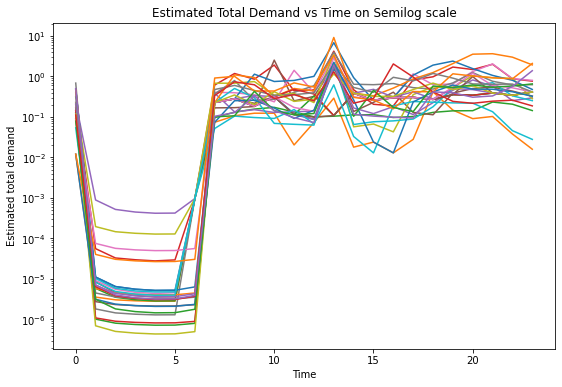

In [9]:
agents = list(range(1, 26))

plt.figure(figsize=(9, 6))
plt.xlabel('Time')
plt.ylabel('Estimated total demand')
plt.title('Estimated Total Demand vs Time on Semilog scale')

for agent_id in agents:
    plt.semilogy(estimateTotalDemand(agent=agent_id, interpolate=False), label=f'Agent {agent_id}')

plt.show()

#### Total Demand Estimation with & without interpolation for bad time slots (1-6)

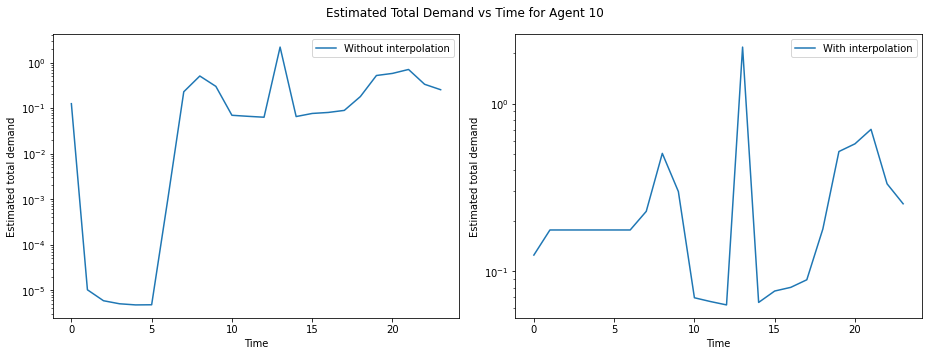

In [10]:
agent = 10
demand_no_interpol = estimateTotalDemand(agent=agent, interpolate=False)
demand_with_interpol = estimateTotalDemand(agent=agent, interpolate=True)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))
fig.suptitle(f'Estimated Total Demand vs Time for Agent {agent}')

ax1.semilogy(demand_no_interpol, label='Without interpolation')
ax2.semilogy(demand_with_interpol, label='With interpolation')

ax1.set_ylabel('Estimated total demand')
ax2.set_ylabel('Estimated total demand')
ax1.set_xlabel('Time')
ax2.set_xlabel('Time')

ax1.legend()
ax2.legend()

fig.tight_layout()

plt.show()

#### MAE in Demand Prediction using GrU with interpolation of estimated total demand

In [11]:
round, agent = 1, 1

d_total = estimateTotalDemand(agent, interpolate=True)
prices = getPriceVectors(round)

d_pred, _ = GrU(d_total, prices)
d_true = getTrueDemandVectors(round, agent)

mae, _ = evaluate(d_true, d_pred[1:, :])
print('MAE in PV Energy demand prediction = ', mae[clock.pv])
print('MAE in Storage Capacity demand prediction = ', mae[clock.storage])
print('MAE in Charging Power demand prediction = ', mae[clock.charge])
print('MAE in Discharging Power demand prediction = ', mae[clock.discharge])

MAE in PV Energy demand prediction =  4.107831574895471e-10
MAE in Storage Capacity demand prediction =  0.7772100742266953
MAE in Charging Power demand prediction =  0.47913186549114456
MAE in Discharging Power demand prediction =  0.08857811070409437


#### Demands from GrU with & without interpolation

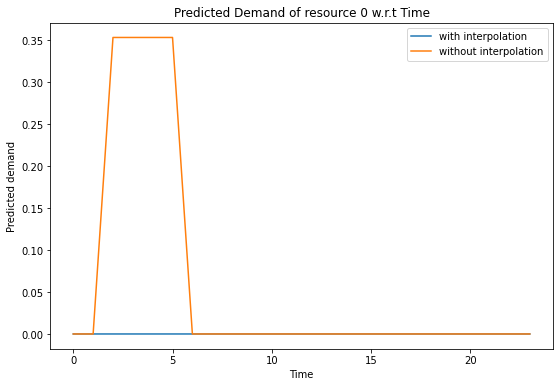

In [12]:
agent, round = 1, 1

prices = getPriceVectors(round)

d_total_no_interpol = estimateTotalDemand(agent, interpolate=False)
d_total_interpol = estimateTotalDemand(agent, interpolate=True)

dem_no_interpol, _ = GrU(d_total_no_interpol, prices)
dem_intrpol, _ = GrU(d_total_interpol, prices)

s = source.grid

plt.figure(figsize=(9, 6))
plt.plot(dem_no_interpol[s], label='with interpolation')
plt.plot(dem_intrpol[s], label='without interpolation')

plt.xlabel('Time')
plt.ylabel('Predicted demand')
plt.title(f'Predicted Demand of resource {s} w.r.t Time')
plt.legend()
plt.show()

#### Mean Absolute Error for all the rounds

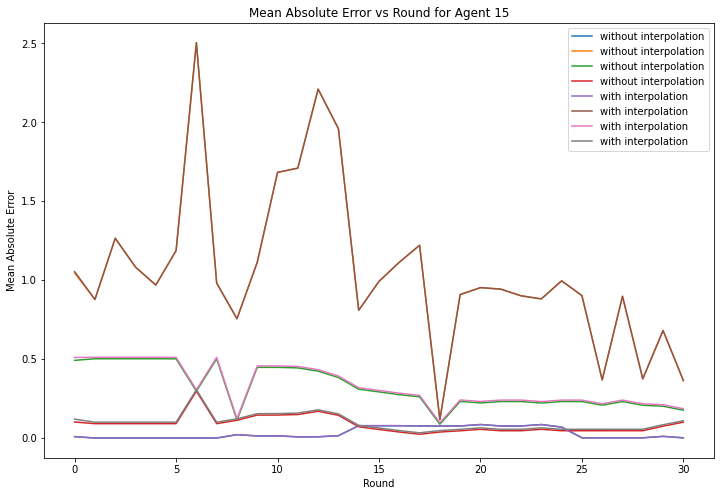

In [13]:
err = []
err_intr = []
agent = 15

d_total_no_interpol = estimateTotalDemand(agent, interpolate=False)
d_total_interpol = estimateTotalDemand(agent, interpolate=True)

for round in range(1, 309, 10):
    prices = getPriceVectors(round)

    dem_pred, _ = GrU(d_total_no_interpol, prices)
    dem_true = getTrueDemandVectors(round, agent)

    mae, _ = evaluate(dem_true, dem_pred[1:])
    err.append(mae)

    dem_pred_intrpol, _ = GrU(d_total_interpol, prices)
    mae_intrpol, _ = evaluate(dem_true, dem_pred_intrpol[1:])
    err_intr.append(mae_intrpol)

err = np.array(err)
err_intr = np.array(err_intr)

plt.figure(figsize=(12, 8))
plt.plot(err, label='without interpolation')
plt.plot(err_intr, label='with interpolation')
# plt.plot(err[:, 0], label='PV Energy')
# plt.plot(err[:, 1], label='Storage Capacity')
# plt.plot(err[:, 2], label='Charging Power')
# plt.plot(err[:, 3], label='Discharging Power')

plt.xlabel('Round')
plt.ylabel('Mean Absolute Error')
plt.title(f'Mean Absolute Error vs Round for Agent {agent}')

plt.legend()
plt.show()

## Experiments with A* Matrices

#### Total demand vector and price vectors

In [14]:
round, agent, T = 100, 10, 24

# Random demand vector
total_d = np.random.rand(24, )

# Price vectors from clock data
prices = np.ndarray((5, 24))
prices[0] = df_auctioneer_data.GRID_PRICE.values
for e in clock:
    prices[e + 1] = df_clock_data[f'price_{round}'][e]

#### Verify that A* matrices give the same output as as the GrU algorithm

In [15]:
A_star = getAStarMatrices( prices, eta_c=0.9487, eta_d=0.9487 )
res = np.ndarray(( 5, 24 ), dtype=float )

## Total demand vector from clock data using Heuristics & no interpolation
# total_d = estimateTotalDemand( agent, interpolate=False )

# Compute separate demand vectors using A* matrices
for e in source:
    res[e] = np.matmul( A_star[e], total_d )

# Compute separate demand vectors using GrU 
gru_out, _ = GrU( total_d, prices, eta_c=0.9487, eta_d=0.9487 )

# Evaluate
for e in source:
    err = np.sum( np.abs( res[e] - gru_out[e] )) / T
    print( e, ' : ', err )

source.grid  :  0.0
source.pv  :  0.0
source.storage  :  2.3245294578089215e-16
source.charge  :  7.401486830834377e-17
source.discharge  :  2.42861286636753e-17


#### Check if the sum of the A* matrices is invertible or not

In [16]:
A_star = getAStarMatrices( prices, eta_c=0.9487, eta_d=0.9487 )
sum_of_A_star = np.zeros( shape=( T, T ))

for e in source:
    sum_of_A_star += A_star[e]

try:
    inv = np.linalg.inv( sum_of_A_star )
    print("Sum of A* matrices is invertible")
except:
    print("Sum of A* matrices is NOT invertible")

Sum of A* matrices is invertible


## Total Demand vector estimation using A* matrices and demand vectors of all the rounds

$
𝐝 = \left( \sum_{r ∈ R}\sum_{∗ ∈ S} (𝐴^∗)^⊤ 𝐴^∗  \right)^+. \left( \sum_{r ∈ R} ∑_{∗ ∈ S} (𝐴^∗)^⊤ 𝐝^∗ \right)
$

R = [0, 309) \
S = {p, c, d, s} \
d = Predicted total demand vector \
d* = Demand vectors from clock data (p, c, d, s)

In [85]:
def estimateTotalDemandUsingAStarAllRounds( agent, T=24, ReLU=True, alpha=1e-6, eta_c = 1, eta_d = 1 ):
    '''
    Estimates total demand vector using A* matrices and demand vectors of all rounds for p, c, d & s.
    Uses the (Moore-Penrose) pseudo-inverse of a matrix to solve the least-squares problem.

    Parameters
    ----------
    agent : int
        Agent number to estimate the total demand vector for, range = [1, 25]

    T : int, default = 24
        Number of time slots (hours) to estimate the total demand vector for.

    ReLU : bool, default = True
        Whether to apply the Rectifier or ReLU Activation function on the estimated total demand vector.

    alpha : float, default = 1e-6
        Laplacian regularization factor for pseudo-inverse.

    eta_c : int, default = 1
        Efficiency constant for charging

    eta_d : int, default = 1
        Efficiency constant for discharging

    Returns
    -------
    d_pred : array of shape (24,)
        Estimated total demand vector.
    '''

    left_term = np.zeros( shape=( T, T ), dtype=float )
    right_term = np.zeros( shape=( T ), dtype=float )

    for round in range(309):
        prices = getPriceVectors( round )
        A_star = getAStarMatrices( prices, T, eta_c, eta_d )[1:]
        d_star = getTrueDemandVectors( round, agent )

        for e in clock:
            left_term += np.matmul( A_star[e].T, A_star[e] )
            right_term += np.matmul( A_star[e].T, d_star[e] )

    d_pred = np.dot( np.linalg.pinv( left_term + alpha * np.eye(T)), right_term )

    if ReLU:
        d_pred[d_pred < 0] = 0

    return d_pred

In [87]:
estimateTotalDemandUsingAStarAllRounds( agent=10, ReLU=False, eta_c=0.9487, eta_d=0.9487, alpha=1e-9 )

array([ 1.24989226e-01,  1.83879078e-07,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -3.33280836e-01,
        1.35990447e-01,  1.05739546e-01,  3.66520675e-01, -1.92717047e-01,
        4.19044234e-01, -1.76059603e-01, -2.72611213e-01,  9.72344388e-02,
        1.51181384e-01,  8.29312875e-02,  4.23569795e-01, -2.47770187e-03,
        2.95459116e-01,  5.73801772e-01,  4.78164257e-01,  3.73479664e-01])

### Evaluate GrU with total demand vector estimated using A* matrices for all rounds with eta = 0.9487

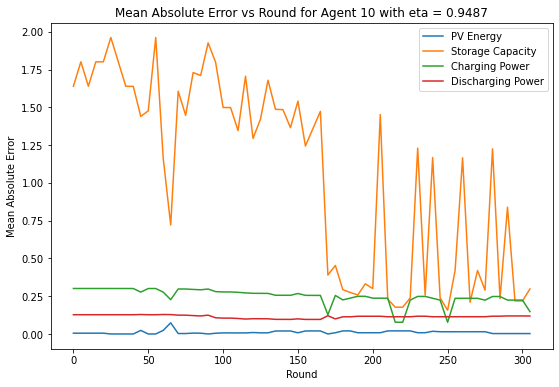

In [88]:
err = []
agent = 10
delta = 5
eta = 0.9487
alpha = 1e-6

# Estimate total demand vector using A* matrices
d_pred = estimateTotalDemandUsingAStarAllRounds( agent, ReLU=True, alpha=alpha, eta_c=eta, eta_d=eta )

for round in range(0, 309, delta):
    # True demand vectors
    d_star = getTrueDemandVectors( round, agent )

    # Feed estimated total demand vector to GrU
    dhat = GrU( d_pred, prices, eta_c=eta, eta_d=eta)[0][1:]

    mae, _ = evaluate(d_star, dhat)
    err.append(mae)

r = np.arange(0, 309, delta)

err = np.array(err)
plt.figure(figsize=(9, 6))
plt.plot(r, err[:, clock.pv], label='PV Energy')
plt.plot(r, err[:, clock.storage], label='Storage Capacity')
plt.plot(r, err[:, clock.charge], label='Charging Power')
plt.plot(r, err[:, clock.discharge], label='Discharging Power')

plt.xlabel('Round')
plt.ylabel('Mean Absolute Error')
plt.title(f'Mean Absolute Error vs Round for Agent {agent} with eta = {eta}')

plt.legend()
plt.show()

### Evaluate GrU with total demand vector estimated using A* matrices for all rounds with eta = 1

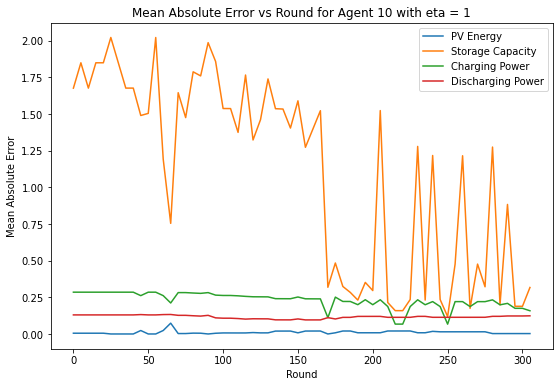

In [89]:
err = []
agent = 10
delta = 5
eta = 1
alpha = 1e-6

# Estimate total demand vector using A* matrices
d_pred = estimateTotalDemandUsingAStarAllRounds( agent, ReLU=True, alpha=alpha, eta_c=eta, eta_d=eta )

for round in range(0, 309, delta):
    # True demand vectors
    d_star = getTrueDemandVectors( round, agent )

    # Feed estimated total demand vector to GrU
    dhat = GrU( d_pred, prices, eta_c=eta, eta_d=eta)[0][1:]

    mae, _ = evaluate(d_star, dhat)
    err.append(mae)

r = np.arange(0, 309, delta)

err = np.array(err)
plt.figure(figsize=(9, 6))
plt.plot(r, err[:, clock.pv], label='PV Energy')
plt.plot(r, err[:, clock.storage], label='Storage Capacity')
plt.plot(r, err[:, clock.charge], label='Charging Power')
plt.plot(r, err[:, clock.discharge], label='Discharging Power')

plt.xlabel('Round')
plt.ylabel('Mean Absolute Error')
plt.title(f'Mean Absolute Error vs Round for Agent {agent} with eta = {eta}')

plt.legend()
plt.show()

## Total Demand vector estimation using A* matrices and demand vectors

$
𝐝 = \left( ∑_{∗ ∈\{𝑝,𝑐,𝑑,𝑠\}} (𝐴^∗)^⊤ 𝐴^∗ \right)^+. \left( ∑_{∗ ∈\{𝑝,𝑐,𝑑,𝑠\}} (𝐴^∗)^⊤ 𝐝^∗ \right)
$
d = Predicted total demand vector \
d* = Demand vectors from clock data (p, c, d, s)

In [61]:
round, agent = 300, 10

d_star = getTrueDemandVectors(round, agent)
prices = getPriceVectors(round)

estimateTotalDemandUsingAStar( prices, d_star, ReLU=False, eta_c=1, eta_d=1 )

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.30812091,  0.27678912,
        0.14234265,  0.06558928,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.0286199 , -0.0341655 ,
       -0.08019762,  0.48507757,  0.46043101,  0.23040269])

### Experiment -> Verify total demand estimation

In [77]:
round, eta_c, eta_d, alpha, T = 200, 0.9487, 0.9487, 1e-12, 24

# Random total demand vector
d_true = np.random.rand(T, )

# Price vectors
prices = getPriceVectors(round)

# GrU (with eta) on random total demand vector
d_star = GrU( d_true, prices, eta_c, eta_d )[0][1:]

# Generate A* matrices
A_star = getAStarMatrices( prices, T, eta_c, eta_d )[1:]

left_term = np.ndarray( shape=( T, T ), dtype=float)
right_term = np.ndarray( shape=( T ), dtype=float)

for e in clock:
    # print(A_star[e].shape, d_star[e].shape)
    left_term += np.matmul( A_star[e].T, A_star[e] )
    right_term += np.matmul( A_star[e].T, d_star[e] )

d_pred = np.dot( np.linalg.pinv( left_term + alpha * np.eye(T)), right_term )

In [78]:
d_star_2 = GrU(d_pred, prices, eta_c=eta_c, eta_d=eta_d )[0][1:]

np.sum(np.abs(d_star_2 - d_star), axis = 1) / 24

array([0.00715906, 0.11943982, 0.03127364, 0.02966931])

### Evaluate GrU with total demand vector estimated using A* matrices with eta = 0.9487

In [83]:
round, agent = 300, 1

d_star = getTrueDemandVectors( round, agent )
prices = getPriceVectors( round )

d_pred = estimateTotalDemandUsingAStar( prices, d_star, ReLU=True, alpha=1e-9, eta_c=0.9487, eta_d=0.9487 )

# Feed estimated total demand vector to GrU with eta = 0.9487
dhat = GrU( d_pred, prices, eta_c=0.9487, eta_d=0.9487 )[0][1:]

mae, mape = evaluate( d_star, dhat )
print('MAE in PV Energy demand prediction = ', mae[clock.pv])
print('MAE in Storage Capacity demand prediction = ', mae[clock.storage])
print('MAE in Charging Power demand prediction = ', mae[clock.charge])
print('MAE in Discharging Power demand prediction = ', mae[clock.discharge])

MAE in PV Energy demand prediction =  0.0113357750881889
MAE in Storage Capacity demand prediction =  0.13770969170131794
MAE in Charging Power demand prediction =  0.04224892505136461
MAE in Discharging Power demand prediction =  0.04799526088162745


### Evaluate GrU with total demand vector estimated using A* matrices without eta

In [82]:
round, agent = 300, 1

d_star = getTrueDemandVectors( round, agent )
prices = getPriceVectors( round )

d_pred = estimateTotalDemandUsingAStar( prices, d_star, ReLU=True, alpha=1e-9, eta_c=1, eta_d=1 )

# Feed estimated total demand vector to GrU with eta = 1
dhat = GrU( d_pred, prices, eta_c=1, eta_d=1 )[0][1:]

mae, mape = evaluate( d_star, dhat )
print('MAE in PV Energy demand prediction = ', mae[clock.pv])
print('MAE in Storage Capacity demand prediction = ', mae[clock.storage])
print('MAE in Charging Power demand prediction = ', mae[clock.charge])
print('MAE in Discharging Power demand prediction = ', mae[clock.discharge])

MAE in PV Energy demand prediction =  0.0113357750881889
MAE in Storage Capacity demand prediction =  0.1572952316156265
MAE in Charging Power demand prediction =  0.03802699068350643
MAE in Discharging Power demand prediction =  0.04437873043635158


### MAE in demand vectors estimation across all the rounds for an agent using A* matrices

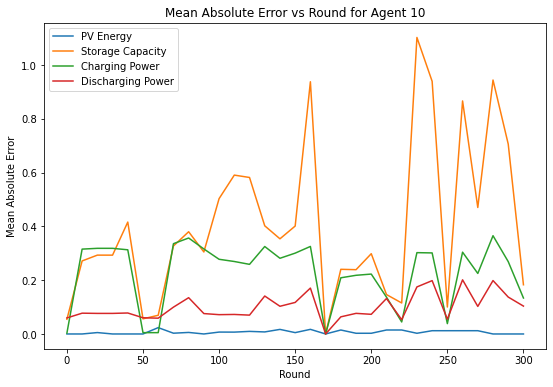

In [84]:
err = []
agent = 10
delta = 10

for round in range(0, 309, delta):
    # True demand vectors
    d_star = getTrueDemandVectors( round, agent )
    prices = getPriceVectors( round )

    # Estimate total demand vector using A* matrices
    d_pred = estimateTotalDemandUsingAStar( prices, d_star, ReLU=True, alpha=1e-9)

    # Feed estimated total demand vector to GrU
    dhat = GrU( d_pred, prices)[0][1:]

    mae, _ = evaluate(d_star, dhat)
    err.append(mae)

r = np.arange(0, 309, delta)

err = np.array(err)
plt.figure(figsize=(9, 6))
plt.plot(r, err[:, 0], label='PV Energy')
plt.plot(r, err[:, 1], label='Storage Capacity')
plt.plot(r, err[:, 2], label='Charging Power')
plt.plot(r, err[:, 3], label='Discharging Power')

plt.xlabel('Round')
plt.ylabel('Mean Absolute Error')
plt.title(f'Mean Absolute Error vs Round for Agent {agent}')

plt.legend()
plt.show()

### Experiment -> Total demand estimation: A* matrices vs Heuristic 

In [21]:
round, T = 100, 24

# Random total demand vector
d_total = np.random.rand(T, )

# Price vectors
prices = getPriceVectors(round)

# Generate demand breakup using GrU
demandBreakup, _ = GrU(d_total, prices)

# Predict total demand vector using A* matrices
P = estimateTotalDemandUsingAStar(prices, demandBreakup[1:])

# Estimate total demand vector as the sum of PV and discharge demand
Q = demandBreakup[source.pv] + demandBreakup[source.discharge]

In [23]:
# Demand breakup using P as total demand vector
d_break_P, util_P = GrU(P, prices)

mae, _ = evaluate(demandBreakup, d_break_P)

print(f'Utility = {util_P}')
print('MAE in Grid Power demand = ', mae[source.grid])
print('MAE in PV Energy demand = ', mae[source.pv])
print('MAE in Storage Capacity demand = ', mae[source.storage])
print('MAE in Charging Power demand = ', mae[source.charge])
print('MAE in Discharging Power demand = ', mae[source.discharge])

Utility = 0.5410816549764812
MAE in Grid Power demand =  0.11905650913869485
MAE in PV Energy demand =  0.0
MAE in Storage Capacity demand =  8.868715600333459e-08
MAE in Charging Power demand =  1.6980705577762656e-08
MAE in Discharging Power demand =  1.1950671240564445e-07


In [24]:
# Demand breakup using P as total demand vector
d_break_Q, util_Q = GrU(Q, prices)

mae, _ = evaluate(demandBreakup, d_break_Q)

print(f'Utility = {util_Q}')
print('MAE in Grid Power demand = ', mae[source.grid])
print('MAE in PV Energy demand = ', mae[source.pv])
print('MAE in Storage Capacity demand = ', mae[source.storage])
print('MAE in Charging Power demand = ', mae[source.charge])
print('MAE in Discharging Power demand = ', mae[source.discharge])

Utility = 0.541081593412255
MAE in Grid Power demand =  0.11905649215798926
MAE in PV Energy demand =  0.0
MAE in Storage Capacity demand =  0.0
MAE in Charging Power demand =  0.0
MAE in Discharging Power demand =  0.0


In [19]:
np.sum(np.absolute(P - Q)) / 24

8.432173137651554e-08

In [20]:
demandBreakup[source.grid]

array([ 0.72467311,  0.        , 10.94536818,  0.45978937,  0.14851078,
        0.61102853,  0.95626784,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [25]:
P

array([0.        , 0.64213811, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.67299414, 0.23060315, 0.03934187,
       0.02860344, 0.44266083, 0.66356995, 0.73264335, 0.28019578,
       0.04847518, 0.40175397, 0.92983917, 0.42972865, 0.53416603,
       0.35127625, 0.77743547, 0.10507069, 0.7242844 ])

In [26]:
Q

array([0.        , 0.64213843, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.67299438, 0.23060311, 0.03934174,
       0.02860327, 0.44266088, 0.66357008, 0.73264353, 0.28019569,
       0.04847494, 0.40175394, 0.92983947, 0.42972856, 0.53416605,
       0.35127613, 0.77743569, 0.10507039, 0.72428456])

## GrU with EI

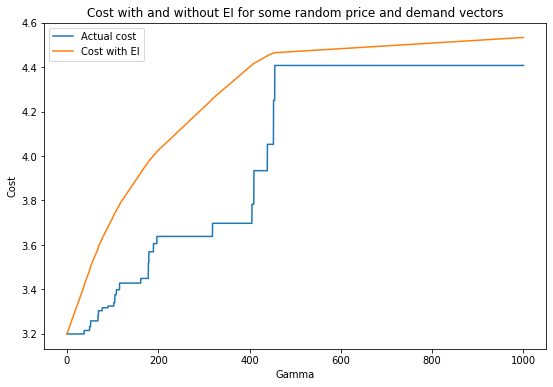

In [78]:
emf = pd.read_csv('../DER sharing/data/community_data_25_17oct.csv')['EMF_17oct15'].to_numpy()

d_total = np.random.rand(24)
prices = getPriceVectors(100)

gammaList = np.linspace(0, 1000, 1000)
cost_with_EI = []
cost_actual = []

for gamma in gammaList:
    prices_with_EI = prices.copy()
    prices_with_EI[source.grid] += gamma * emf

    breakup, _ = GrU(d_total, prices_with_EI)

    cost_with_EI += [getCost(prices_with_EI, breakup)]
    cost_actual += [getCost(prices, breakup)]

plt.figure(figsize=(9, 6))
plt.plot(gammaList, cost_actual, label='Actual cost')
plt.plot(gammaList, cost_with_EI, label='Cost with EI')

plt.xlabel('Gamma')
plt.ylabel('Cost')
plt.title('Cost with and without EI for some random price and demand vectors')

plt.legend()
plt.show()